# Signal Processing with OpenSignals Data

This notebook demonstrates loading and analyzing OpenSignals data from Bitalino devices.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
from pathlib import Path
from scipy.signal import butter, filtfilt, freqz, welch, spectrogram

## Loading the Data Files

We have two data files:
- `.txt` file: OpenSignals text format with metadata
- `.h5` file: HDF5 binary format

In [2]:
# Load the text file
txt_file = '../data/sample_data/opensignals_84BA20AEBFDA_2025-10-04_12-25-49.txt'

# Read metadata from header
with open(txt_file, 'r') as f:
    lines = f.readlines()
    
# Extract metadata from second line (JSON format)
metadata_line = lines[1].strip('# \n')
metadata = json.loads(metadata_line)

print("Device Metadata:")
device_info = list(metadata.values())[0]
for key, value in device_info.items():
    print(f"{key}: {value}")

Device Metadata:
position: 0
device: bitalino_rev
device name: 84:BA:20:AE:BF:DA
device connection: BTH84:BA:20:AE:BF:DA
sampling rate: 1000
resolution: [4, 1, 1, 1, 1, 10, 10, 10, 10, 6, 6]
firmware version: 1282
comments: 
keywords: 
mode: 0
sync interval: 2
date: 2025-10-4
time: 12:25:52.503
channels: [1, 2, 3, 4, 5, 6]
sensor: ['RAW', 'RAW', 'RAW', 'RAW', 'RAW', 'RAW']
label: ['A1', 'A2', 'A3', 'A4', 'A5', 'A6']
column: ['nSeq', 'I1', 'I2', 'O1', 'O2', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6']
special: [{}, {}, {}, {}, {}, {}]
digital IO: [0, 0, 1, 1]
convertedValues: 0


In [3]:
# Load the actual data (skip header lines)
data_txt = pd.read_csv(txt_file, sep='\t', skiprows=3, header=None)

# Remove any empty columns (trailing tabs create empty columns)
data_txt = data_txt.dropna(axis=1, how='all')

# Set column names based on metadata
columns = device_info['column']
if len(data_txt.columns) == len(columns):
    data_txt.columns = columns
else:
    print(f"Warning: Data has {len(data_txt.columns)} columns but metadata specifies {len(columns)} columns")
    # Use generic column names if mismatch
    data_txt.columns = [f'col_{i}' for i in range(len(data_txt.columns))]

print(f"Data shape: {data_txt.shape}")
print(f"\nColumn names: {list(data_txt.columns)}")
print(f"\nFirst few rows:")
data_txt.head()

Data shape: (11850, 11)

Column names: ['nSeq', 'I1', 'I2', 'O1', 'O2', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6']

First few rows:


,nSeq,I1,I2,O1,O2,A1,A2,A3,A4,A5,A6
0,0,0,0,0,0,510,510,0,1018,39,21
1,1,0,0,0,0,505,508,0,1018,39,21
2,2,0,0,0,0,510,508,0,1018,39,21
3,3,0,0,0,0,514,510,0,1018,39,21
4,4,0,0,0,0,512,509,1,1019,39,21


## Data Visualization

Let's visualize the analog channels (A1-A6) to see what the signals look like.

Plotting channels: ['A1', 'A2', 'A3', 'A4', 'A5', 'A6']


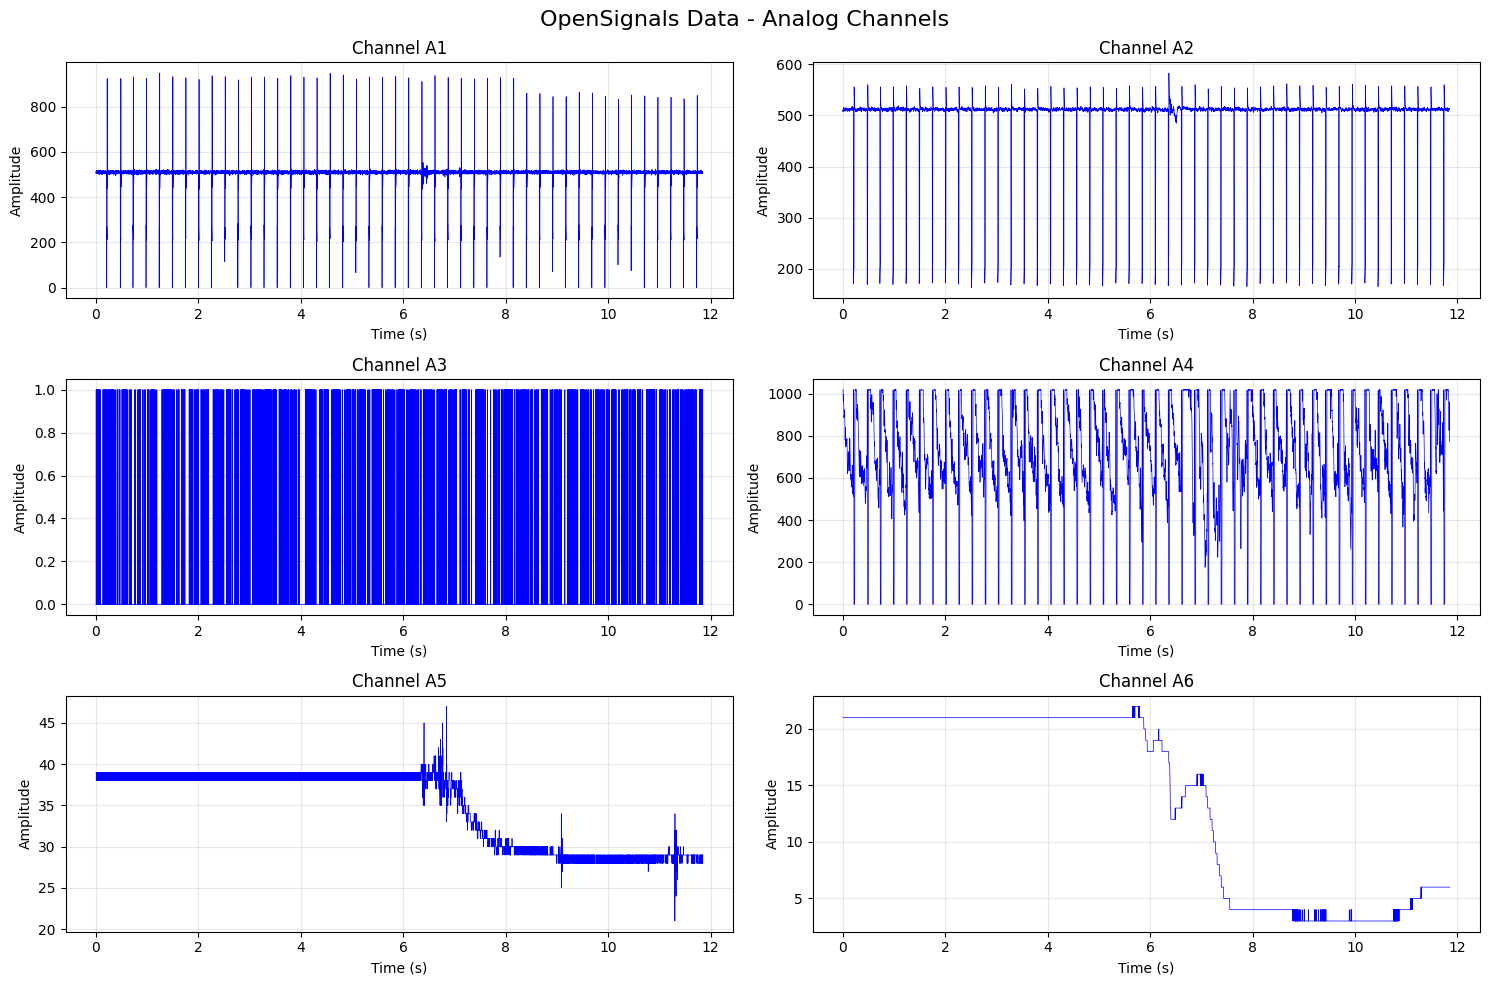

In [4]:
# Create time axis (sampling rate is 1000 Hz)
sampling_rate = device_info['sampling rate']
time = np.arange(len(data_txt)) / sampling_rate

# Plot analog channels - find columns that contain analog data
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('OpenSignals Data - Analog Channels', fontsize=16)

# Try to identify analog channels from the data
if 'A1' in data_txt.columns:
    analog_channels = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6']
else:
    # Use the last 6 columns as analog channels (typical for Bitalino)
    analog_channels = data_txt.columns[-6:].tolist()

print(f"Plotting channels: {analog_channels}")

for i, channel in enumerate(analog_channels):
    if i >= 6:  # Only plot first 6 channels
        break
    row = i // 2
    col = i % 2
    
    axes[row, col].plot(time, data_txt[channel], 'b-', linewidth=0.5)
    axes[row, col].set_title(f'Channel {channel}')
    axes[row, col].set_xlabel('Time (s)')
    axes[row, col].set_ylabel('Amplitude')
    axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

We did a simple experiment with X axis electrodes on channel 4 so lets extract the signal from channel 4.

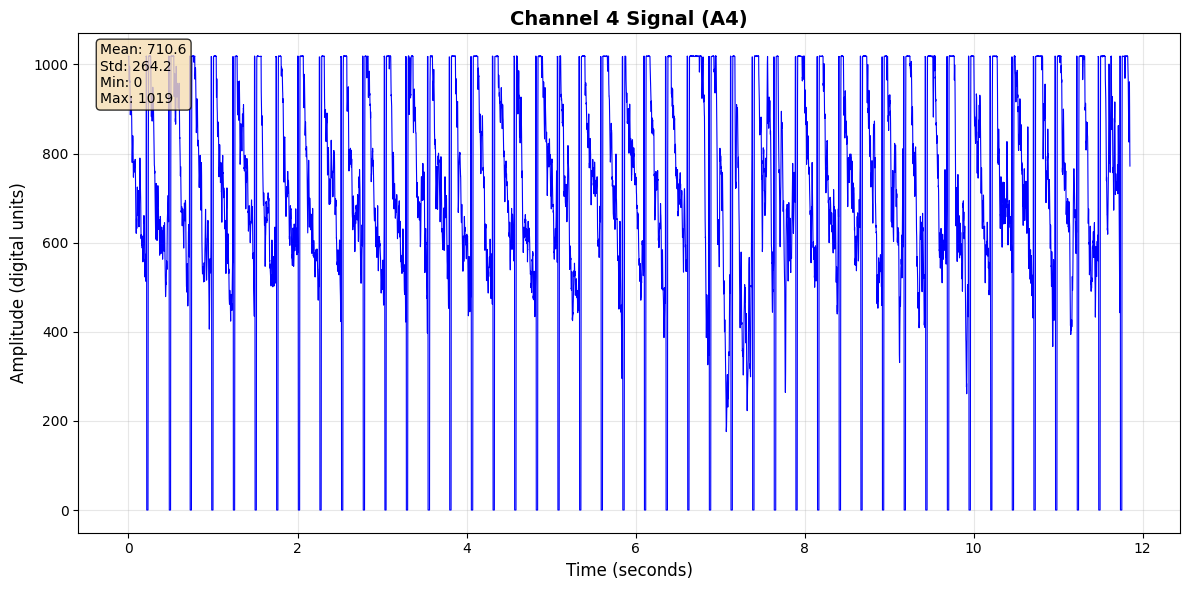

Channel 4 (A4) Statistics:
Duration: 11.85 seconds
Samples: 11850
Mean: 710.63
Standard deviation: 264.18
Range: 0 to 1019


In [5]:
# Plot Channel 4 data specifically
plt.figure(figsize=(12, 6))

# Determine which column represents channel 4
if 'A4' in data_txt.columns:
    channel_4_data = data_txt['A4']
    channel_name = 'A4'
elif len(data_txt.columns) >= 9:  # Assuming channel 4 is the 9th column (nSeq, I1, I2, O1, O2, A1, A2, A3, A4)
    channel_4_data = data_txt.iloc[:, 8]  # 9th column (0-indexed)
    channel_name = data_txt.columns[8]
else:
    # Fallback: use 4th column from the end (assuming last 6 are analog channels)
    channel_4_data = data_txt.iloc[:, -3]  # 4th from end
    channel_name = data_txt.columns[-3]

# Create time axis
time = np.arange(len(channel_4_data)) / sampling_rate

# Plot the signal
plt.plot(time, channel_4_data, 'b-', linewidth=0.8)
plt.title(f'Channel 4 Signal ({channel_name})', fontsize=14, fontweight='bold')
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Amplitude (digital units)', fontsize=12)
plt.grid(True, alpha=0.3)

# Add some basic statistics as text
mean_val = np.mean(channel_4_data)
std_val = np.std(channel_4_data)
min_val = np.min(channel_4_data)
max_val = np.max(channel_4_data)

stats_text = f'Mean: {mean_val:.1f}\nStd: {std_val:.1f}\nMin: {min_val}\nMax: {max_val}'
plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"Channel 4 ({channel_name}) Statistics:")
print(f"Duration: {len(channel_4_data) / sampling_rate:.2f} seconds")
print(f"Samples: {len(channel_4_data)}")
print(f"Mean: {mean_val:.2f}")
print(f"Standard deviation: {std_val:.2f}")
print(f"Range: {min_val} to {max_val}")

## Transfer Functions: Converting sensor data into physical units

Sensor data acquired with BITalino and biosignalsplux devices are represented in the digitized sensor values ranging between 0 and 2^(sampling resolution – 1) due to the analog to digital conversion of the acquired sensor signal.

Using OpenSignals, you can export sensor data in their digital value format or convert the signals into their original physical units.

- [BITalino Sensor Documentation](https://bitalino.com/documentation)
- [biosignalsplux Sensor Documentation](https://biosignalsplux.com/documentation)

You can find below an example of how to apply the transfer function.

**EOG(mV) = (ADC/2^(n-1) - 0.5) × VCC × Gecg**

We can define the parameters of the transfer function as follows:

In [6]:
# ADC: Digital values of the EOG signal
eog_digital = channel_4_data

# n: Sampling resolution of the signal 10 bit
sampling_resolution = 10

# VCC: the sensor's operating voltage of 3.3V
# Datasheet ref: https://support.pluxbiosignals.com/wp-content/uploads/2021/11/eog-sensor-datasheet-rev.pdf
vcc = 3.3

# Gecg: the sensor's gain
# Datasheet ref: https://support.pluxbiosignals.com/wp-content/uploads/2021/11/eog-sensor-datasheet-rev.pdf
gain = 2038

Using these parameters, the resulting transfer function to convert the ECG signal back into mV would be as follows:

In [8]:
# Convert ECG signal into V and mV
eog_V = (eog_digital / (2**sampling_resolution) - 0.5) * vcc / gain
eog_mV = (eog_digital / (2**sampling_resolution) - 0.5) * vcc / gain * 1000

In [9]:
def plot_signal(signal, plot_title, sampling_rate, amplitude_units = "V"):
    # Create time axis
    plt.figure(figsize=(12, 6))
    time = np.arange(len(signal)) / sampling_rate

    # Plot the signal
    plt.plot(time, signal, 'b-', linewidth=0.8)
    plt.title(plot_title, fontsize=14, fontweight='bold')
    plt.xlabel('Time (seconds)', fontsize=12)
    plt.ylabel(f'Amplitude {amplitude_units}', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

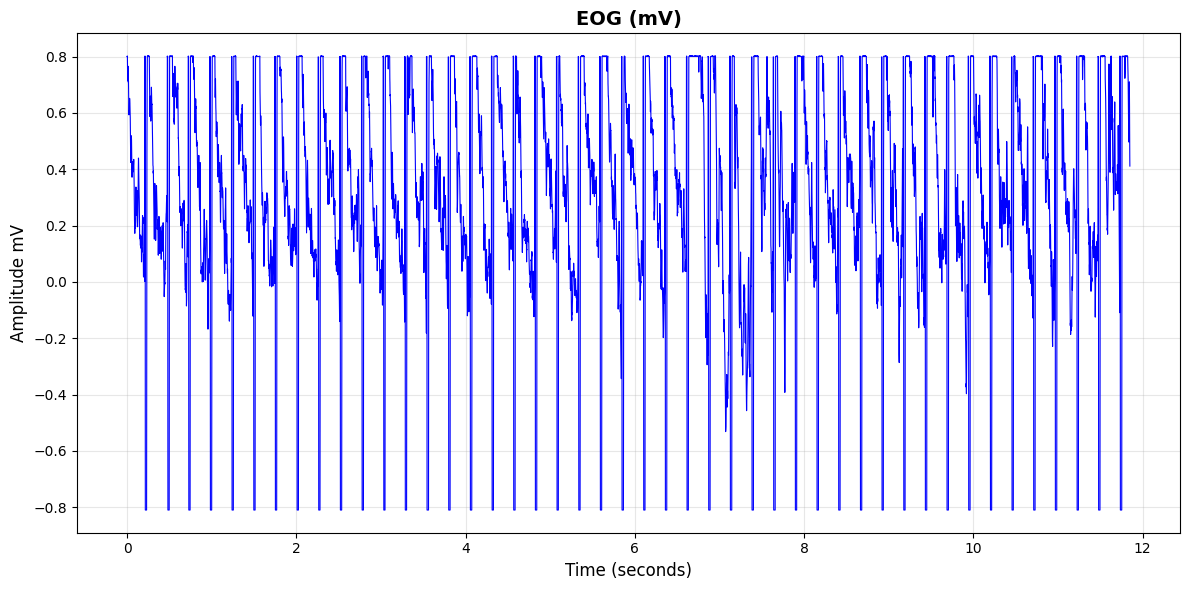

In [10]:
plot_signal(eog_mV, "EOG (mV)", sampling_rate, "mV")

Oof extremely noisy data but we can continue with it for now...

## Signals Processing: Playing with Filters

In [11]:
def butter_filter(filter_type, cutoff, fs, order=4, band=None):
    nyq = 0.5 * fs
    if filter_type == 'low':
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low')
    elif filter_type == 'high':
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='high')
    elif filter_type == 'band':
        low, high = band
        b, a = butter(order, [low/nyq, high/nyq], btype='band')
    return b, a

def apply_filter(signal, b, a):
    return filtfilt(b, a, signal)


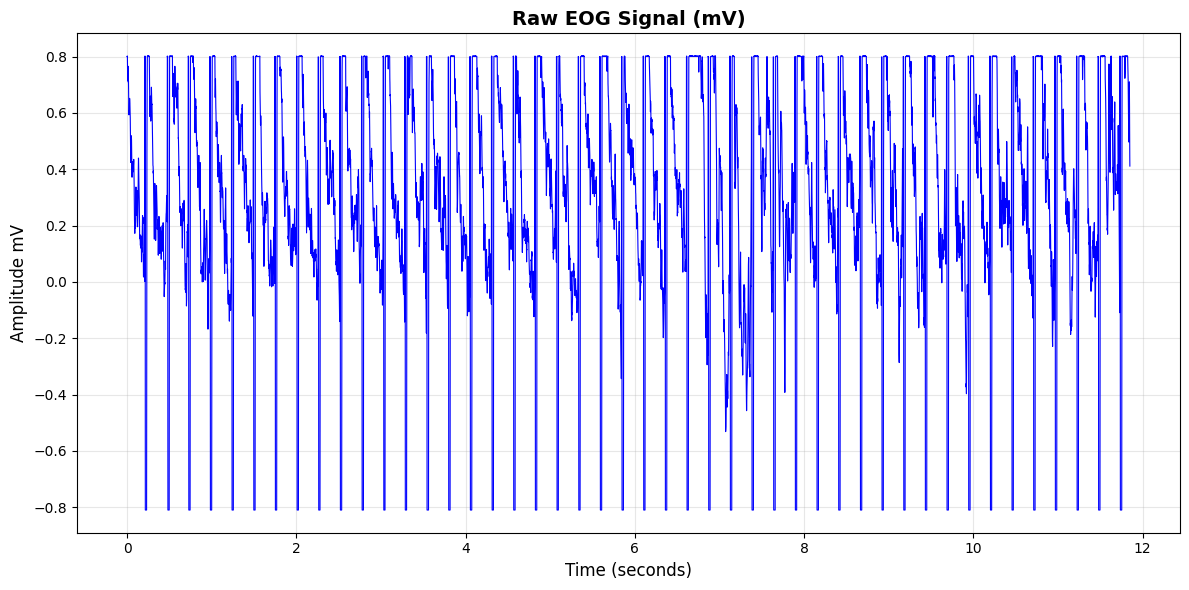

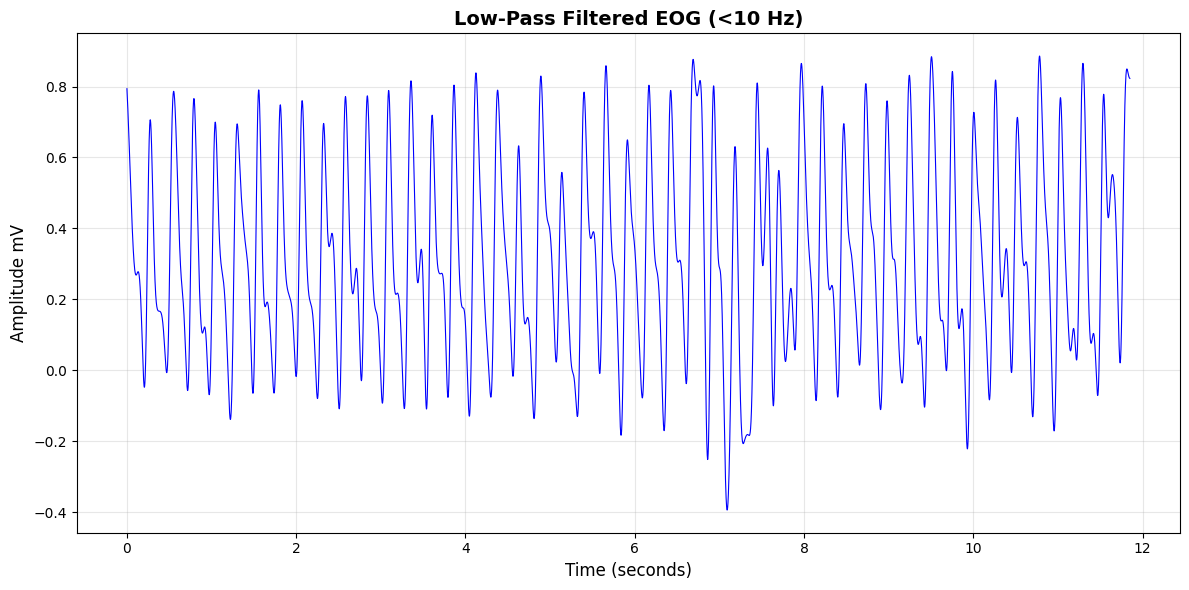

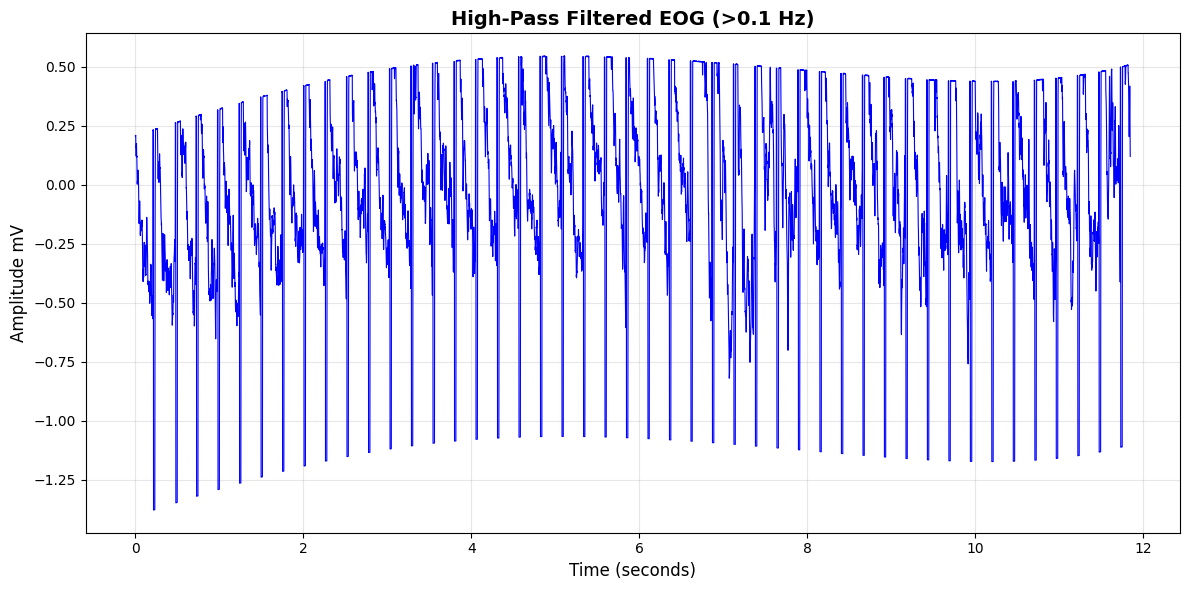

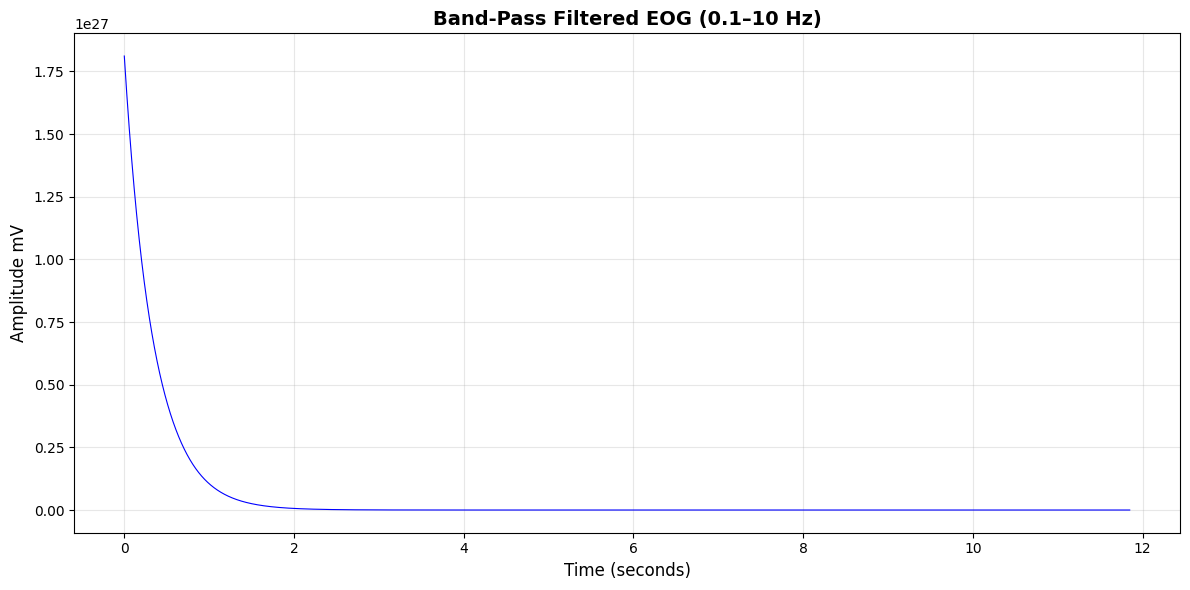

In [12]:
# --- Filter parameters ---
low_cutoff = 10      # Hz
high_cutoff = 0.1    # Hz
band_cutoff = (0.1, 10)  # Hz

# --- Create filters ---
b_low, a_low = butter_filter('low', low_cutoff, sampling_rate)
b_high, a_high = butter_filter('high', high_cutoff, sampling_rate)
b_band, a_band = butter_filter('band', None, sampling_rate, band=band_cutoff)

# --- Apply filters ---
eog_low = apply_filter(eog_mV, b_low, a_low)
eog_high = apply_filter(eog_mV, b_high, a_high)
eog_band = apply_filter(eog_mV, b_band, a_band)

# --- Plot comparisons ---
plot_signal(eog_mV, "Raw EOG Signal (mV)", sampling_rate, "mV")
plot_signal(eog_low, "Low-Pass Filtered EOG (<10 Hz)", sampling_rate, "mV")
plot_signal(eog_high, "High-Pass Filtered EOG (>0.1 Hz)", sampling_rate, "mV")
plot_signal(eog_band, "Band-Pass Filtered EOG (0.1–10 Hz)", sampling_rate, "mV")


# Frequency Response of Filters

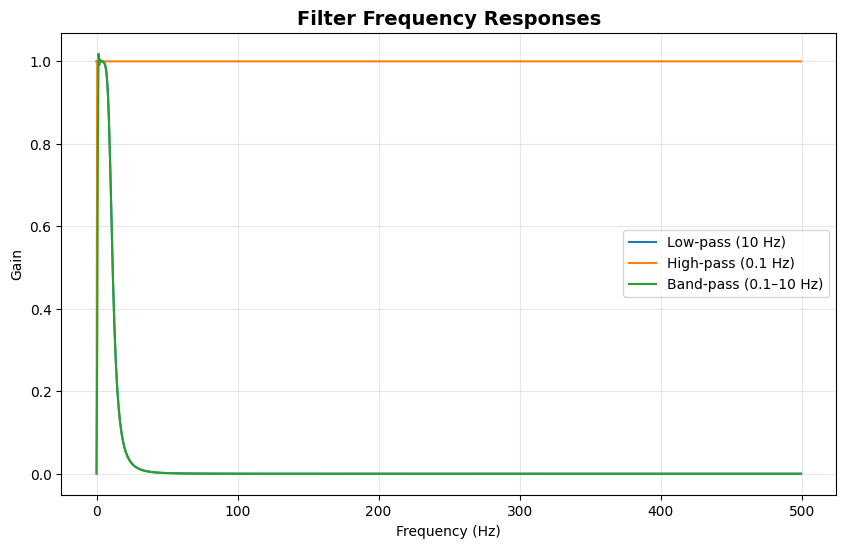

In [13]:
plt.figure(figsize=(10, 6))
for (b, a, label) in [(b_low, a_low, 'Low-pass (10 Hz)'),
                      (b_high, a_high, 'High-pass (0.1 Hz)'),
                      (b_band, a_band, 'Band-pass (0.1–10 Hz)')]:
    w, h = freqz(b, a, worN=1024)
    plt.plot((sampling_rate * 0.5 / np.pi) * w, abs(h), label=label)

plt.title("Filter Frequency Responses", fontsize=14, fontweight='bold')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


# Spectogram

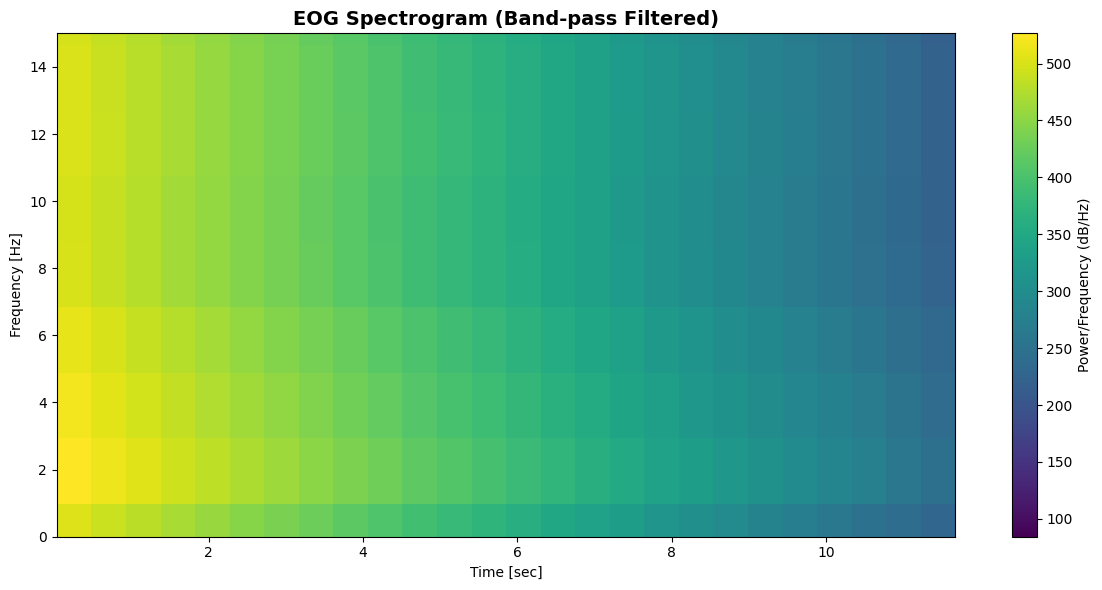

In [14]:
f, t, Sxx = spectrogram(eog_band, fs=sampling_rate, nperseg=512)
plt.figure(figsize=(12, 6))
plt.pcolormesh(t, f, 10*np.log10(Sxx), shading='auto')
plt.title('EOG Spectrogram (Band-pass Filtered)', fontsize=14, fontweight='bold')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.ylim(0, 15)
plt.tight_layout()
plt.show()
